In this notebook, we will analyze a set of selected stocks, and calculate a given stock's "beta to the market", as one way of assessing the risk of that stock.


## Setup



Installing packages:

In [ ]:
%%capture
!pip install yahooquery

In [ ]:
import plotly.express as px
from yahooquery import Ticker
from pandas import to_datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Challenges

### Part 1: Fetching Stock Data

First, update the `symbols` list provided in the cell below, to choose your own list of 5-10 valid stock symbols.

Then run all cells in Part 1 to fetch historical price data for the designated symbols, as well as the market. This data will be stored in a dataframe variable called `histories_df`.

In [ ]:
# choose your own stocks here (at least five):
symbols = ["AAPL", "GOOGL", "META",
           "MSFT", "NFLX", "AMZN", "NVDA",
           "BAC", "JPM"
]

In [ ]:
# https://yahooquery.dpguthrie.com/guide/ticker/intro/

# adding market index as well (leave this as is):
all_symbols = symbols + ["SPY"]

companies = Ticker(all_symbols)
print(type(companies))

<class 'yahooquery.ticker.Ticker'>


In [ ]:
companies.history()

open        high         low       close     volume  \
symbol date                                                                    
AAPL   2023-01-03  130.279999  130.899994  124.169998  125.070000  112117500   
       2023-01-04  126.889999  128.660004  125.080002  126.360001   89113600   
       2023-01-05  127.129997  127.769997  124.760002  125.019997   80962700   
       2023-01-06  126.010002  130.289993  124.889999  129.619995   87754700   
       2023-01-09  130.470001  133.410004  129.889999  130.149994   70790800   
...                       ...         ...         ...         ...        ...   
SPY    2023-10-23  419.609985  424.450012  417.799988  420.459991   92035100   
       2023-10-24  422.649994  424.820007  420.739990  423.630005   78564200   
       2023-10-25  421.890015  421.920013  417.019989  417.549988   94223200   
       2023-10-26  416.450012  417.329987  411.600006  412.549988  115156800   
       2023-10-27  414.190002  414.600006  409.209991  410.679993  107228400   

                     adjclose  dividends  
symbol date                               
AAPL   2023-01-03  124.538658        0.0  
       2023-01-04  125.823189        0.0  
       2023-01-05  124.488876        0.0  
       2023-01-06  129.069321        0.0  
       2023-01-09  129.597061        0.0  
...                       ...        ...  
SPY    2023-10-23  420.459991        0.0  
       2023-10-24  423.630005        0.0  
       2023-10-25  417.549988        0.0  
       2023-10-26  412.549988        0.0  
       2023-10-27  410.679993        0.0  

[2070 rows x 7 columns]

In [ ]:
# the prices data is accessible via history method
# ... but it has a multi-level index
# ... so we are simplifying the index to make our lives easier:
histories_df = companies.history()
histories_df["symbol"] = histories_df.index.get_level_values(0)
histories_df["date"] = to_datetime(histories_df.index.get_level_values(1)).date
histories_df.reset_index(drop=True, inplace=True) # use default index (0-based)

histories_df[["date", "symbol", "adjclose"]]

,date,symbol,adjclose
0,2023-01-03,AAPL,124.538658
1,2023-01-04,AAPL,125.823189
2,2023-01-05,AAPL,124.488876
3,2023-01-06,AAPL,129.069321
4,2023-01-09,AAPL,129.597061
...,...,...,...
2065,2023-10-23,SPY,420.459991
2066,2023-10-24,SPY,423.630005
2067,2023-10-25,SPY,417.549988
2068,2023-10-26,SPY,412.549988


In [ ]:
# checking number of rows and structure:
print("ROWS:", len(histories_df))
print(histories_df["symbol"].value_counts())

ROWS: 2070
symbol
AAPL     207
GOOGL    207
META     207
MSFT     207
NFLX     207
AMZN     207
NVDA     207
BAC      207
JPM      207
SPY      207
Name: count, dtype: int64


In [ ]:
# quick check for null values (because in theory, some stocks may have different history lengths, for example recent IPO vs older company)
nulls_count = histories_df["adjclose"].isnull().sum()
assert nulls_count == 0 #> 0 ok looks good. can proceed without concern for nulls

In [ ]:
# quick chart of the market (this chart df shouldn't need to be used for anything else later, just here for charting purposes)
# filtering because right now data is row per symbol per date, so we'd have many different rows for the same date unless we choose just a single symbol
chart_df = histories_df[histories_df["symbol"] == "SPY"]
px.line(chart_df, y="adjclose", x="date", title="Market (SPY)", height=350,
        labels={"date": "Date", "adjclose": "Adjusted Close"}
)

### Part 2: Restructuring the Data





Use the `histories_df` dataframe provided in Part 1, which is structured as: a row per stock symbol per date.

Manipulate the data to format it instead as: a row per date, with a column per symbol, and corresponding cell values of the closing price for that symbol on that day (see example table, below). Store this new dataframe in a variable called `prices_pivot`.

> HINT: use the [`DataFrame.pivot()` function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html) or another pivot-based approach


<img width="1218" alt="Screenshot 2023-10-23 at 6 27 04 PM" src="https://github.com/prof-rossetti/intro-to-python/assets/1328807/ec3dd0f4-0049-40e4-a624-eedd29003846">


Questions:

  + 2-A) How many trading days (i.e. rows) are in the provided data?
  + 2-B) What is the earliest date and latest date in the provided data?
  + 2-C) For each stock: print the symbol, as well as that stock's minimum, maximum, and mean price.


In [ ]:
df = histories_df.pivot(index='date', columns='symbol', values='adjclose')
df.head()

symbol,AAPL,AMZN,BAC,GOOGL,JPM,META,MSFT,NFLX,NVDA,SPY
date,,,,,,,,,,
2023-01-03,124.538658,85.820000,32.757507,89.120003,131.208878,124.739998,237.956329,294.950012,143.099091,376.639587
2023-01-04,125.823189,85.139999,33.373360,88.080002,132.432419,127.370003,227.547363,309.410004,147.437561,379.547333
2023-01-05,124.488876,83.120003,33.304932,86.199997,132.403061,126.940002,220.803360,309.700012,142.599258,375.215424
2023-01-06,129.069321,86.080002,33.637299,87.339996,134.936661,130.020004,223.405609,315.549988,148.537155,383.819885
2023-01-09,129.597061,87.360001,33.128975,88.019997,134.379074,129.470001,225.580765,315.170013,156.224411,383.602264


In [ ]:
# 2-A)
print("The number of trading days are:",len(df))
print("----------------------")
# 2-B)
print("The earliest date is",df.index.min().strftime('%Y-%m-%d'))
print("----------------------")
print("The latest date is",df.index.max().strftime('%Y-%m-%d'))
print("----------------------")
# 2-C)
for i in df.columns:
    print("The symbol is:",i)
    print("The minimum price for",i,"is",df[i].min())
    print("The maximum price for",i,"is",df[i].max())
    print("The average price for",i,"is",df[i].mean())
    print("----------------------")

The number of trading days are: 207
----------------------
The earliest date is 2023-01-03
----------------------
The latest date is 2023-10-27
----------------------
The symbol is: AAPL
The minimum price for AAPL is 124.48887634277344
The maximum price for AAPL is 196.18507385253906
The average price for AAPL is 168.82926601833768
----------------------
The symbol is: AMZN
The minimum price for AMZN is 83.12000274658203
The maximum price for AMZN is 144.85000610351562
The average price for AMZN is 116.27202926856884
----------------------
The symbol is: BAC
The minimum price for BAC is 25.170000076293945
The maximum price for BAC is 35.94430160522461
The average price for BAC is 29.620051499150225
----------------------
The symbol is: GOOGL
The minimum price for GOOGL is 86.19999694824219
The maximum price for GOOGL is 140.5500030517578
The average price for GOOGL is 115.64067652605581
----------------------
The symbol is: JPM
The minimum price for JPM is 122.19036865234375
The maximu

### Part 3: Daily Returns

Each stock price is different, but we want to compare their performance, so let's compare them in relative terms.

Process the `prices_pivot` from Part 2, to calculate each stock's percent change in price since the previous day (see example table below). Store this new dataframe in a variable called `returns_df`.

> HINT: consider an approach that loops through the `all_symbols` variable, and creates a new returns column for each symbol

> HINT: leverage the [`DataFrame.pct_change()` function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pct_change.html), as demonstrated in the professor's "Pandas Package Overview Mega Notebook"

> NOTE: returns for each stock on the first / earliest day should be 0.0

<img width="1223" alt="Screenshot 2023-10-24 at 12 47 02 AM" src="https://github.com/prof-rossetti/intro-to-python/assets/1328807/7ea0fa1c-7254-46f5-b08f-a64084ebf06d">

Questions:

  + 3-A) For each stock: print the symbol, as well as that stock's minimum, maximum, and mean daily returns. Also print the standard deviation of returns.

  + 3-B) Consider standard deviation of returns as a measure of how much a given stock may vary over time, and thus a basic measure of risk. Which stocks' returns have the highest (and lowest) standard deviations?


In [ ]:
returns_df = df.copy()

In [ ]:
returns_df = returns_df.pct_change(periods=1)
returns_df = returns_df.fillna(0)
for i in returns_df.columns:
    returns_df = returns_df.rename(columns={i: i+"_returns"})
returns_df.head()

symbol,AAPL_returns,AMZN_returns,BAC_returns,GOOGL_returns,JPM_returns,META_returns,MSFT_returns,NFLX_returns,NVDA_returns,SPY_returns
date,,,,,,,,,,
2023-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-01-04,0.010314,-0.007924,0.018800,-0.011670,0.009325,0.021084,-0.043743,0.049025,0.030318,0.007720
2023-01-05,-0.010605,-0.023726,-0.002050,-0.021344,-0.000222,-0.003376,-0.029638,0.000937,-0.032816,-0.011413
2023-01-06,0.036794,0.035611,0.009980,0.013225,0.019136,0.024263,0.011785,0.018889,0.041640,0.022932
2023-01-09,0.004089,0.014870,-0.015112,0.007786,-0.004132,-0.004230,0.009736,-0.001204,0.051753,-0.000567


In [ ]:
# 3-A)
variation_dict = {}
for i in returns_df.columns:
    print("The symbol is:",i.replace("_returns", ""))
    print("The minimum daily returns for",i.replace("_returns", ""),"is",returns_df[i].min())
    print("The maximum daily returns for",i.replace("_returns", ""),"is",returns_df[i].max())
    print("The average daily returns for",i.replace("_returns", ""),"is",returns_df[i].mean())
    print("The standard deviation of daily returns for",i.replace("_returns", ""),"is",returns_df[i].std())
    variation_dict[i.replace("_returns", "")] = returns_df[i].std()
    print("----------------------")
# 3B
print("The company which has the highest standart deviation on its returns is",max(variation_dict, key=variation_dict.get),"with as standart deviation of",variation_dict[max(variation_dict, key=variation_dict.get)])
print("The company which has the lowest standart deviation on its returns is",min(variation_dict, key=variation_dict.get),"with as standart deviation of",variation_dict[min(variation_dict, key=variation_dict.get)])

The symbol is: AAPL
The minimum daily returns for AAPL is -0.04802007285706045
The maximum daily returns for AAPL is 0.04692691378665437
The average daily returns for AAPL is 0.0015389054305811882
The standard deviation of daily returns for AAPL is 0.013109954738879255
----------------------
The symbol is: AMZN
The minimum daily returns for AMZN is -0.08431497620839845
The maximum daily returns for AMZN is 0.08269337801006271
The average daily returns for AMZN is 0.0021632725440850218
The standard deviation of daily returns for AMZN is 0.021999839696869562
----------------------
The symbol is: BAC
The minimum daily returns for BAC is -0.062039346709445886
The maximum daily returns for BAC is 0.04974212251332433
The average daily returns for BAC is -0.0011372108449346694
The standard deviation of daily returns for BAC is 0.016430375143632686
----------------------
The symbol is: GOOGL
The minimum daily returns for GOOGL is -0.09509399308699129
The maximum daily returns for GOOGL is 0.07

### Part 4: Cumulative Growth

Process the `prices_pivot` from Part 2, to calculate each stock's cumulative growth in prices since the earliest provided date (see example table below). Store this new dataframe in a variable called `growth_df`.

> HINT: consider an approach that loops through the `all_symbols` variable, and creates a new growth column for each symbol

> HINT: leverage the [`DataFrame.cumprod()` function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.cumprod.html), as demonstrated in the professor's "Pandas Package Overview Mega Notebook"

> NOTE: growth for each stock on the first / earliest day should be 1.0


<img width="1288" alt="Screenshot 2023-10-23 at 6 27 20 PM" src="https://github.com/prof-rossetti/intro-to-python/assets/1328807/9ba9f25d-e6e1-48f3-a599-e813d078a85c">


Then plot the cumulative growth for all the stocks and the market on the same graph (see example plot below).

<img width="1306" alt="Screenshot 2023-10-23 at 6 27 32 PM" src="https://github.com/prof-rossetti/intro-to-python/assets/1328807/f04bc8a2-d7b8-4d58-90e4-3b3ff056d223">


Questions:

  + 4-A) Which company has the highest cumulative growth since the beginning of the period?
  + 4-B) Which companies have performed better (or worse) than the market ("SPY") over this period?




In [ ]:
cumulative_growth_df = returns_df.copy()

In [ ]:
for i in cumulative_growth_df.columns:
    cumulative_growth_df[i] = (cumulative_growth_df[i] + 1).cumprod()
print(cumulative_growth_df.tail(5))
fig = px.line(cumulative_growth_df, x=cumulative_growth_df.index, y=cumulative_growth_df.columns, labels={'date': 'Date', 'value': 'Value'}, title='Stock Returns VS. Market')
fig.show()

symbol      AAPL_returns  AMZN_returns  BAC_returns  GOOGL_returns  \
date                                                                 
2023-10-23      1.389127      1.474714     0.780584       1.531643   
2023-10-24      1.392660      1.498019     0.777532       1.557563   
2023-10-25      1.373871      1.414472     0.779974       1.409448   
2023-10-26      1.340066      1.393265     0.797374       1.372083   
2023-10-27      1.350745      1.488464     0.768373       1.370848   

symbol      JPM_returns  META_returns  MSFT_returns  NFLX_returns  \
date                                                                
2023-10-23     1.074622      2.517316      1.383951      1.379352   
2023-10-24     1.075918      2.505612      1.389036      1.402712   
2023-10-25     1.070050      2.401235      1.431649      1.394304   
2023-10-26     1.072793      2.311608      1.377942      1.368164   
2023-10-27     1.034153      2.378788      1.386011      1.348940   

symbol      NVDA_returns 

In [ ]:
# 4-A)
y = -float('inf')
for i in cumulative_growth_df.columns:
    if y <= cumulative_growth_df[i].iloc[-1]:
        y = cumulative_growth_df[i].iloc[-1]
        x = i.replace("_returns", "")
print("The company with the highest cumulative growth is",x,"with a cumulative growh rate of",str(y)+".")
print("----------------------")
# 4-B)
v = cumulative_growth_df["SPY_returns"].iloc[-1]
print("The following companies have a higher growth rate then the SPY over the given period")
for i in cumulative_growth_df.columns:
    if i != "SPY_returns":
        if v < cumulative_growth_df[i].iloc[-1]:
            print(i.replace("_returns", "")+":",cumulative_growth_df[i].iloc[-1])
print("----------------------")
w = cumulative_growth_df["SPY_returns"].iloc[-1]
print("The following companies have a lower growth rate then the SPY over the given period")
for i in cumulative_growth_df.columns:
    if i != "SPY_returns":
        if w > cumulative_growth_df[i].iloc[-1]:
            print(i.replace("_returns", "")+":",cumulative_growth_df[i].iloc[-1])
print("----------------------")

The company with the highest cumulative growth is NVDA with a cumulative growh rate of 2.8302066656700213.
----------------------
The following companies have a higher growth rate then the SPY over the given period
AAPL: 1.3507452523599202
AMZN: 1.4884642078537964
GOOGL: 1.3708482316404669
META: 2.378788007599548
MSFT: 1.3860106115498447
NFLX: 1.348940426006542
NVDA: 2.8302066656700213
----------------------
The following companies have a lower growth rate then the SPY over the given period
BAC: 0.768373485417339
JPM: 1.0341526043141553
----------------------


### Part 5: Correlation

Use the `returns_df` from Part 3 to calculate the Spearman correlation between each pair of stocks.

> HINT: use the [`DataFrame.corr()` function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html)

Then plot this correlation matrix as a heatmap (see example plot below).

<img width="639" alt="Screenshot 2023-10-24 at 1 00 42 AM" src="https://github.com/prof-rossetti/intro-to-python/assets/1328807/1c040530-6923-48de-9a02-d8a9a3352373">

Questions:

  + 5-A) The correlation matrix has all 1.0 values on the main diagonal. What does this mean?

  + 5-B) Which pair or pairs of companies are most positively (and negatively) correlated with eachother?

  + 5-C) Which companies are most positively (and negatively) correlated with the market?

  + 5-D) Choose one of the stocks from your analysis. If you own that stock, which other stock from your analysis should you consider buying if you want to hedge your risk?


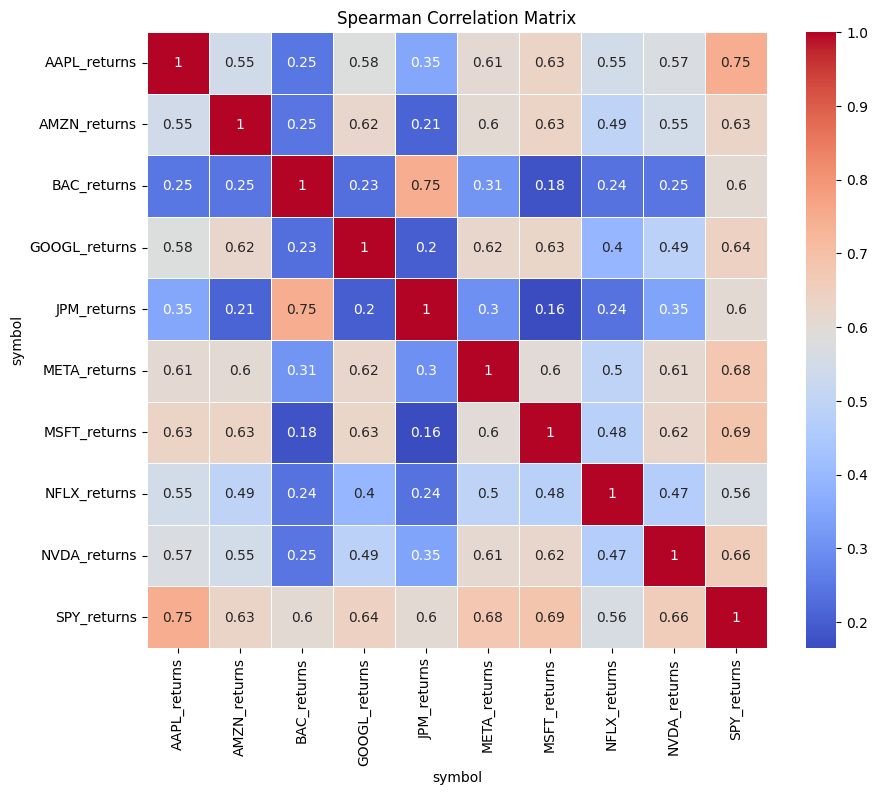

In [ ]:
correlation_stocks = returns_df.corr(method='spearman', min_periods=1, numeric_only=False)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_stocks, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Spearman Correlation Matrix')
plt.show()

5-A) The diagonal of a correlation matrix has a value of 1 because it represents the correlation of a variable with itself. This is because any variable has a perfect correlation with itself and can be expressed with a correlation coefficient of 1.

In [ ]:
# 5-B)
# Most positively correlated
a = float('-inf')
ticker1 = None
ticker2 = None
for i in correlation_stocks.columns:
    for j in correlation_stocks.index:
        if i != j and i != 'SPY_returns' and j != 'SPY_returns':
            if a <= correlation_stocks.loc[j, i]:
                a = correlation_stocks.loc[j, i]
                ticker1 = i.replace("_returns", "")
                ticker2 = j.replace("_returns", "")
print("The most positively correlated companies are",ticker1,"and", ticker2,"with a correlation of", a)
print("----------------------")
# Most negatively correlated
b = float('inf')
ticker1 = None
ticker2 = None
for i in correlation_stocks.columns:
    for j in correlation_stocks.index:
        if i != j and i != 'SPY_returns' and j != 'SPY_returns':
            if b >= correlation_stocks.loc[j, i]:
                b = correlation_stocks.loc[j, i]
                ticker1 = i.replace("_returns", "")
                ticker2 = j.replace("_returns", "")
print("The most positively correlated companies are",ticker1,"and", ticker2,"with a correlation of", b)
print("----------------------")
# 5-C)
# Most negatively correlated
c = float('-inf')
ticker1 = None
ticker2 = None
for i in correlation_stocks.columns:
    for j in correlation_stocks.index:
        if i != j and i != 'SPY_returns' and j == 'SPY_returns':
            if c <= correlation_stocks.loc[j, i]:
                c = correlation_stocks.loc[j, i]
                ticker1 = i.replace("_returns", "")
                ticker2 = j.replace("_returns", "")
print("The most positively correlated company to the", ticker2,"is", ticker1,"with a correlation of", c)
print("----------------------")
d = float('inf')
ticker1 = None
ticker2 = None
for i in correlation_stocks.columns:
    for j in correlation_stocks.index:
        if i != j and i != 'SPY_returns' and j == 'SPY_returns':
            if d >= correlation_stocks.loc[j, i]:
                d = correlation_stocks.loc[j, i]
                ticker1 = i.replace("_returns", "")
                ticker2 = j.replace("_returns", "")
print("The most negatively correlated company to the", ticker2,"is", ticker1,"with a correlation of", d)
print("----------------------")
# 5-D)
print("The stock chosen for the analysis is NVDA")
e = float('inf')
ticker1 = None
ticker2 = None
for i in correlation_stocks.columns:
    for j in correlation_stocks.index:
        if i != j and i != 'SPY_returns' and i != 'NVDA_returns' and j == 'NVDA_returns':
            if e >= correlation_stocks.loc[j, i]:
                e = correlation_stocks.loc[j, i]
                ticker1 = i.replace("_returns", "")
                ticker2 = j.replace("_returns", "")
print("I would consider buying",ticker1,"to hedge my risk aginst",ticker2+". As",ticker1,"has the largest negative correlation to",ticker1,"with a correlation of",e)

The most positively correlated companies are JPM and BAC with a correlation of 0.7457533558982619
----------------------
The most positively correlated companies are MSFT and JPM with a correlation of 0.16459665984782068
----------------------
The most positively correlated company to the SPY is AAPL with a correlation of 0.7477657778935298
----------------------
The most negatively correlated company to the SPY is NFLX with a correlation of 0.5642935203014957
----------------------
The stock chosen for the analysis is NVDA
I would consider buying BAC to hedge my risk aginst NVDA. As BAC has the largest negative correlation to BAC with a correlation of 0.2461245704819098


## Further Exploration

### Part 6: Calculating Beta to the Market (Optional)

Optionally tackle this further exploration challenge, related to calculating beta to the market.




#### Understanding Beta

https://www.investopedia.com/ask/answers/070615/what-formula-calculating-beta.asp


> Beta is a measure used in fundamental analysis to determine the volatility of an asset or portfolio in relation to the overall market. The overall market has a beta of 1.0, and individual stocks are ranked according to how much they deviate from the market.

> A stock that swings more than the market over time has a beta greater than 1.0. If a stock moves less than the market, the stock's beta is less than 1.0. High-beta stocks tend to be riskier but provide the potential for higher returns. Low-beta stocks pose less risk but typically yield lower returns.

> As a result, beta is often used as a risk-reward measure, meaning it helps investors determine how much risk they are willing to take to achieve the return for taking on that risk. A stock's price variability is important to consider when assessing risk. If you think of risk as the possibility of a stock losing its value, beta is useful as a proxy for risk.



> To calculate the beta of a security, the covariance between the return of the security and the return of the market must be known, as well as the variance of the market returns.



\begin{align}
        Beta = \frac{Covariance} {Variance}
\end{align}



Where:
  + Covariance = Measure of a stock's return relative to that of the market
  + Variance = Measure of how the market moves relative to its mean


> **Covariance** measures how two stocks move together. A positive covariance means the stocks tend to move together when their prices go up or down. A negative covariance means the stocks move opposite of each other.

> **Variance**, on the other hand, refers to how far a stock moves relative to its mean. For example, variance is used in measuring the volatility of an individual stock's price over time. Covariance is used to measure the correlation in price moves of two different stocks.

> The formula for calculating beta is the covariance of the return of an asset with the return of the benchmark, divided by the variance of the return of the benchmark over a certain period.

#### Calculating Beta


We saw from the "Understanding Beta" section that we need to calculcate the variance of the market, as well as the covariance of each stock with respect to the market.

Luckily pandas makes this easy.

##### Variance

https://www.investopedia.com/terms/v/variance.asp

<img src="https://www.investopedia.com/thmb/_hIorwcVnDj-oKWhpTu_qnuUldM=/750x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/Variance-TAERM-ADD-Source-464952914f77460a8139dbf20e14f0c0.jpg" height=300>

> FYI: standard deviation is the square root of the variance!

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.var.html



In [ ]:
returns_df.var()

symbol
AAPL_returns     0.000172
AMZN_returns     0.000484
BAC_returns      0.000270
GOOGL_returns    0.000403
JPM_returns      0.000192
META_returns     0.000718
MSFT_returns     0.000276
NFLX_returns     0.000633
NVDA_returns     0.001056
SPY_returns      0.000072
dtype: float64

In [ ]:
returns_df.std() ** 2 # squaring the standard deviation, is equivalent to the variance

symbol
AAPL_returns     0.000172
AMZN_returns     0.000484
BAC_returns      0.000270
GOOGL_returns    0.000403
JPM_returns      0.000192
META_returns     0.000718
MSFT_returns     0.000276
NFLX_returns     0.000633
NVDA_returns     0.001056
SPY_returns      0.000072
dtype: float64

##### Covariance

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.cov.html

> Computes the pairwise covariance among the series of a DataFrame. The returned data frame is the covariance matrix of the columns of the DataFrame.

> This method is generally used for the analysis of time series data to understand the relationship between different measures across time.

In [ ]:
cov_mat = returns_df.cov()
cov_mat

symbol,AAPL_returns,AMZN_returns,BAC_returns,GOOGL_returns,JPM_returns,META_returns,MSFT_returns,NFLX_returns,NVDA_returns,SPY_returns
symbol,,,,,,,,,,
AAPL_returns,0.000172,0.000124,0.000046,0.000142,0.000053,0.000193,0.000118,0.000138,0.000186,0.000081
AMZN_returns,0.000124,0.000484,0.000062,0.000269,0.000035,0.000338,0.000208,0.000200,0.000262,0.000114
BAC_returns,0.000046,0.000062,0.000270,0.000057,0.000167,0.000096,0.000030,0.000069,0.000096,0.000079
GOOGL_returns,0.000142,0.000269,0.000057,0.000403,0.000047,0.000328,0.000168,0.000155,0.000261,0.000106
JPM_returns,0.000053,0.000035,0.000167,0.000047,0.000192,0.000073,0.000018,0.000049,0.000109,0.000063
META_returns,0.000193,0.000338,0.000096,0.000328,0.000073,0.000718,0.000234,0.000211,0.000347,0.000136
MSFT_returns,0.000118,0.000208,0.000030,0.000168,0.000018,0.000234,0.000276,0.000154,0.000290,0.000088
NFLX_returns,0.000138,0.000200,0.000069,0.000155,0.000049,0.000211,0.000154,0.000633,0.000242,0.000095
NVDA_returns,0.000186,0.000262,0.000096,0.000261,0.000109,0.000347,0.000290,0.000242,0.001056,0.000152


If we want to calculate the covariance of "this with respect to that", we can access the specific value from this matrix. For example, the covariance of NFLX with respect to the market:

In [ ]:
# if we have well defined index and columns, we can use the loc method and specify the name of the row, then the name of the column
# ... df.loc[row_name, col_name]

cov_mat.loc["NFLX_returns", "SPY_returns"]

9.480059292332573e-05

##### Beta

Calculating beta to the market (choose your own symbol as desired):

In [ ]:
## calculating beta to market for a given company:
symbol = "NVDA"
#
## get covariance between this stock and the market
cov_mat = returns_df.cov()
cov = cov_mat.loc[symbol + "_returns", "SPY_returns"] # using loc method to access a given [row, col] combo
print(f"COVARIANCE OF {symbol} WITH RESPECT TO THE MARKET:", cov)

COVARIANCE OF NVDA WITH RESPECT TO THE MARKET: 0.0001521294893808803


In [ ]:
var = returns_df["SPY_returns"].var()
print(f"VARIANCE OF THE MARKET:", var)

VARIANCE OF THE MARKET: 7.154091414263133e-05


In [ ]:
beta = cov / var
print(f"BETA OF {symbol} WITH RESPECT TO THE MARKET:", round(beta,3))

BETA OF NVDA WITH RESPECT TO THE MARKET: 2.126


https://www.investopedia.com/investing/beta-gauging-price-fluctuations/

Questions:

  + 6-A) How can we interpret this beta value? What does it tell us about the company's stock, and the risk involved?

The beta measures the volatility of a stock(NVDA) with relation to the market(SPY). In this case the beta is 2.126 which means that NVDA grows at a rate of 2.126 times the growth of SPY but there is also a higher risk involved with the stock. Beta is just one of many factors to consider when determining the growth and risk involved with a stock.